In [1]:
from ppxgboost import PPPrediction as prediction
import ppxgboost.PPModel as PPModel
from ppxgboost import PaillierAPI as paillier
import ppxgboost.OPEMetadata as OPEMetadata
import ppxgboost.PPKey as PPKey
import ppxgboost.PPQuery as PPQuery
import random
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from secrets import token_bytes
import pyope.ope as pyope

# XGBoost HE

### Data Preparation and Train an XGBoost ML model

Update the path of train and test dataset below to your local directory that has the datasets.

In [24]:
train = pd.read_csv('../data/train_encoded.csv')
test = pd.read_csv('../data/test_encoded.csv')

In [25]:
AttributeLabels = train.columns.tolist()[:-1]

X_train = train[AttributeLabels]
X_train = pd.DataFrame(X_train, columns=AttributeLabels)
y_train = train[['Overall Survival Status']]

X_test = test[AttributeLabels]
X_test = pd.DataFrame(X_test, columns=AttributeLabels)
y_test = test[['Overall Survival Status']]

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=AttributeLabels)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=AttributeLabels)
X_train.head()

,DNA Input,Fraction Genome Altered,Metastatic Site,Mutation Count,Sample Class,Sample Collection Source,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,...,Smoking History_Unknown,Specimen Preservation Type_Cell Pellet,Specimen Preservation Type_DNA,Specimen Preservation Type_FFPE,Specimen Preservation Type_FNA,Specimen Preservation Type_Other,Specimen Type_Biopsy,Specimen Type_CUSA,Specimen Type_Cytology,Specimen Type_Resection
0,-2.851067,-1.017535,1.131688,-0.370990,0.0,-0.732289,-0.325915,0.721340,-1.140771,-0.994379,...,-0.44753,-0.041315,-0.469931,0.472839,-0.01145,0.0,-0.906920,-0.01145,4.091682,-0.984521
1,0.317901,0.094304,-0.883636,-0.012136,0.0,-0.732289,-0.325915,1.705198,0.876600,1.005652,...,-0.44753,-0.041315,-0.469931,0.472839,-0.01145,0.0,1.102633,-0.01145,-0.244398,-0.984521
2,0.317901,1.221505,1.131688,-0.131754,0.0,-0.732289,-0.325915,0.259225,-1.140771,-0.994379,...,-0.44753,-0.041315,2.127971,-2.114885,-0.01145,0.0,-0.906920,-0.01145,-0.244398,1.015722
3,0.317901,-0.024878,1.131688,-0.311181,0.0,-0.732289,-0.325915,1.466687,-1.140771,1.005652,...,-0.44753,-0.041315,-0.469931,0.472839,-0.01145,0.0,1.102633,-0.01145,-0.244398,-0.984521
4,0.317901,0.319426,1.131688,-0.370990,0.0,-0.732289,-0.325915,0.139970,-1.140771,-0.994379,...,-0.44753,-0.041315,-0.469931,0.472839,-0.01145,0.0,-0.906920,-0.01145,-0.244398,1.015722


In [27]:
y_train.head()

,Overall Survival Status
0,0
1,0
2,1
3,0
4,0


In [28]:
X_test.head()

,DNA Input,Fraction Genome Altered,Metastatic Site,Mutation Count,Sample Class,Sample Collection Source,Number of Samples Per Patient,Sample coverage,Sample Type,Sex,...,Smoking History_Unknown,Specimen Preservation Type_Cell Pellet,Specimen Preservation Type_DNA,Specimen Preservation Type_FFPE,Specimen Preservation Type_FNA,Specimen Preservation Type_Other,Specimen Type_Biopsy,Specimen Type_CUSA,Specimen Type_Cytology,Specimen Type_Resection
0,0.317901,-0.203917,1.131688,-0.430799,0.0,-0.732289,-0.325915,-1.440165,0.876600,1.005652,...,-0.447530,-0.041315,-0.469931,0.472839,-0.01145,0.0,-0.906920,-0.01145,-0.244398,1.015722
1,0.317901,-0.585300,1.131688,-0.311181,0.0,1.365582,-0.325915,0.426928,-1.140771,-0.994379,...,2.234487,-0.041315,-0.469931,0.472839,-0.01145,0.0,-0.906920,-0.01145,-0.244398,1.015722
2,0.317901,-0.006339,1.131688,-0.191563,0.0,1.365582,-0.325915,0.385934,-1.140771,-0.994379,...,-0.447530,-0.041315,-0.469931,0.472839,-0.01145,0.0,1.102633,-0.01145,-0.244398,-0.984521
3,0.317901,0.714582,1.131688,-0.370990,0.0,-0.732289,-0.325915,-0.556930,-1.140771,1.005652,...,-0.447530,-0.041315,-0.469931,0.472839,-0.01145,0.0,1.102633,-0.01145,-0.244398,-0.984521
4,0.317901,-0.598013,-0.883636,-0.430799,0.0,1.365582,2.415437,-0.232704,0.876600,1.005652,...,-0.447530,-0.041315,-0.469931,0.472839,-0.01145,0.0,-0.906920,-0.01145,-0.244398,1.015722


In [29]:
# Train a xgboost model 
dtrain = xgb.DMatrix(X_train, label=y_train)
params = {'eta': 0.1,'subsample': 0.8, 'max_depth': 5, 
          'gamma': 0.1, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'scale_pos_weight':3}
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=50)

# predict using the plaintext prediction
start = time.time()
plaintext_predict = model.predict(xgb.DMatrix(X_test))
end = time.time()
print("XGBoost Prediction : Elapsed Time: ", end - start)

XGBoost Prediction : Elapsed Time:  0.006360054016113281


In [30]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

binary_predictions = [1 if p >= 0.5 else 0 for p in plaintext_predict]

accuracy = accuracy_score(y_test, binary_predictions)

f1 = f1_score(y_test, binary_predictions)

roc_auc = roc_auc_score(y_test, binary_predictions)

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC AUC score:", roc_auc)

Accuracy: 0.6148215919487648
F1-score: 0.5125434195291393
ROC AUC score: 0.6434761183406034


### Encryption Preparation for XGBoost Model
1. Set up some metadata information for the dataset.
2. Set up the encryption materials
3. Encrypt the model
4. Encrypt the query
5. Perform the prediction
6. Decrypt the prediction

In [31]:
# 0. Create custom data ranges
in_range = pyope.ValueRange(pyope.DEFAULT_IN_RANGE_START, 2 ** 43 - 1)
out_range = pyope.ValueRange(pyope.DEFAULT_OUT_RANGE_START, 2 ** 63 - 1)

# 1. parsing to internal tree data structure, and output feature set
start = time.time()
queries = PPQuery.pandas_to_queries(X_test)
qmin, qmax = PPQuery.get_test_data_extreme_values(queries)
ppModel = PPModel.from_xgboost_model(model)

# 2. Set up encryption materials.
ppModelKey, ppQueryKey = PPKey.generatePPXGBoostKeys(in_range, out_range)

# 3. process the tree into ppmodel
metadata = OPEMetadata.OPEMetadata(ppModel, qmin, qmax, in_range.end)
features = ppModel.get_features()

enc_model = ppModel.encrypt(ppModelKey, metadata)

# 4. Encrypts the input vector for prediction (using prf_key_hash and ope-encrypter) based on the feature set.
queryEncryptor = PPQuery.QueryEncryptor(ppQueryKey, features, metadata)
enc_queries = PPQuery.encrypt_queries(queryEncryptor, queries)
end = time.time()
print("PPXGBoost Encryption : Elapsed Time:", round(end - start, 2), "seconds")

PPXGBoost Encryption : Elapsed Time: 1541.4 seconds


In [32]:
# 5. privacy-preserving evaluation.
start = time.time()
values = prediction.predict_binary(enc_model, enc_queries)
end = time.time()
print("PPXGBoost Prediction : Elapsed Time: ", end - start)

PPXGBoost Prediction : Elapsed Time:  76.46661186218262


In [33]:
# 6. decryption
decryptions = []

start = time.time()
for c in values:
    decryptions.append(paillier.decrypt(ppQueryKey.get_private_key(), c))
end = time.time()
print("PPXGBoost Decryption : Elapsed Time: ", end - start)

decryptions = np.array([round(x, 7) for x in decryptions])
decryptions = [1 if p >= 0.5 else 0 for p in decryptions]

assert len(plaintext_predict) == len(decryptions)

# check if the prediction metrics are same (the ppxgboost might not produce same values - as the plaintext value due to precision)

accuracy = accuracy_score(y_test, decryptions)

f1 = f1_score(y_test, decryptions)

roc_auc = roc_auc_score(y_test, decryptions)

print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC AUC score:", roc_auc)

PPXGBoost Decryption : Elapsed Time:  358.7454991340637
Accuracy: 0.5986581274778896
F1-score: 0.46806790622473726
ROC AUC score: 0.6048475114526108


**Now let's run it 5 times kfold to plot results with error bars**

In [38]:
from sklearn.model_selection import KFold

data = pd.read_csv('../data/combined_encoded.csv')

AttributeLabels = train.columns.tolist()[:-1]

X = data[AttributeLabels]
y = data['Overall Survival Status']

acc = []
f1 = []
roc_auc = []

acc_encrypted = []
f1_encrypted = []
roc_auc_encrypted = []

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# loop through splits
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")

    # splitting the data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]

    # scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=AttributeLabels)
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=AttributeLabels)

    # training the model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {'eta': 0.1,'subsample': 0.8, 'max_depth': 5, 
              'gamma': 0.1, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'scale_pos_weight':3}
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=50)

    # plain predictions & metrics
    plaintext_predict = model.predict(xgb.DMatrix(X_test))
    binary_predictions = [1 if p >= 0.5 else 0 for p in plaintext_predict]
    
    acc.append(accuracy_score(y_test, binary_predictions))   
    f1.append(f1_score(y_test, binary_predictions)) 
    roc_auc.append(roc_auc_score(y_test, binary_predictions))

    # encrypting the test queries
    in_range = pyope.ValueRange(pyope.DEFAULT_IN_RANGE_START, 2 ** 43 - 1)
    out_range = pyope.ValueRange(pyope.DEFAULT_OUT_RANGE_START, 2 ** 63 - 1)
    queries = PPQuery.pandas_to_queries(X_test)
    qmin, qmax = PPQuery.get_test_data_extreme_values(queries)
    ppModel = PPModel.from_xgboost_model(model)
    ppModelKey, ppQueryKey = PPKey.generatePPXGBoostKeys(in_range, out_range)
    metadata = OPEMetadata.OPEMetadata(ppModel, qmin, qmax, in_range.end)
    features = ppModel.get_features()
    enc_model = ppModel.encrypt(ppModelKey, metadata)
    queryEncryptor = PPQuery.QueryEncryptor(ppQueryKey, features, metadata)
    enc_queries = PPQuery.encrypt_queries(queryEncryptor, queries)


    # privacy preserved evaluation - prediction
    values = prediction.predict_binary(enc_model, enc_queries)

    # decryption of the results and calculating metrics
    decryptions = []
    for c in values:
        decryptions.append(paillier.decrypt(ppQueryKey.get_private_key(), c))
        
    decryptions = np.array([round(x, 7) for x in decryptions])
    decryptions = [1 if p >= 0.5 else 0 for p in decryptions]

    acc_encrypted.append(accuracy_score(y_test, decryptions))

    f1_encrypted.append(f1_score(y_test, decryptions))
    
    roc_auc_encrypted.append(roc_auc_score(y_test, decryptions))

print("# PLAIN EVALUATION RESULTS")
print(acc)
print(f1)
print(roc_auc)

print("# ENCRYPTED EVALUATION RESULTS")
print(acc_encrypted)
print(f1_encrypted)
print(roc_auc_encrypted)


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# PLAIN EVALUATION RESULTS
[0.6090742438130156, 0.6081576535288726, 0.6127406049495875, 0.6070609812012838, 0.605685465382852]
[0.5094882116158712, 0.5150311968235961, 0.519613416714042, 0.5043377674956623, 0.49941792782305006]
[0.6496313607539204, 0.6419592009721171, 0.6405355242519152, 0.6387913240336918, 0.6343572094416885]
# ENCRYPTED EVALUATION RESULTS
[0.5994500458295142, 0.5472043996333639, 0.5572868927589367, 0.5543328748280605, 0.5547913801008711]
[0.43612903225806454, 0.4653679653679654, 0.47783783783783784, 0.48680042238648363, 0.4837852206273259]
[0.5885171854121999, 0.5877879318658077, 0.5944248586544815, 0.6145399840197091, 0.611878162765922]


In [41]:
f1_ = [np.mean(f1), np.mean(f1_encrypted)]
f1_std = [np.std(f1), np.std(f1_encrypted)]

roc_ = [np.mean(roc_auc), np.mean(roc_auc_encrypted)]
roc_std = [np.std(roc_auc), np.std(roc_auc_encrypted)]

acc_ = [np.mean(acc), np.mean(acc_encrypted)]
acc_std = [np.std(acc), np.std(acc_encrypted)]

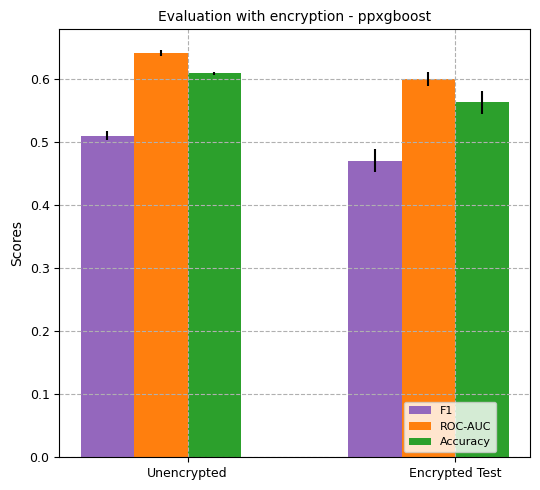

In [55]:
import matplotlib.pyplot as plt

model_names = ['Unencrypted', 'Encrypted Test']
x = np.arange(len(model_names))
width = 0.2
fig, ax = plt.subplots(figsize=(5.5, 5))

rects1 = ax.bar(x=x - width, height=f1_, width=width, label='F1', color='#9467bd', yerr=f1_std)  # Purple
rects2 = ax.bar(x=x, height=roc_, width=width, label='ROC-AUC', color='#ff7f0e', yerr=roc_std)  # Orange
rects3 = ax.bar(x=x + width, height=acc_, width=width, label='Accuracy', color='#2ca02c', yerr=acc_std)  # Green

ax.set_ylabel('Scores', fontsize=10)
ax.set_title('Evaluation with encryption - ppxgboost', fontsize=10)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(model_names, fontsize=9)
ax.legend(loc='lower center', bbox_to_anchor=(.83, 0), fontsize=8)
ax.tick_params(axis='y', labelsize=9)
ax.grid(True, linestyle='--')
fig.tight_layout()
plt.show()
